# Reinforcement Learning Example: The Jogger

### Going Jogging
In this notebook, we will explore reinforcement learning in a small, simple state space: Our agent starts at home (left), wants to jog to the target (right), and make it back home. When reaching
this goal, the agent is rewarded a large reward R and goes to sleep, terminating our game in state BED. In each time step, the agent can move one to the left, one to the right, or stay where it is.

<img align="center" style="max-width: 900px" src="illustration.jpg">

### The Challenge: Rain
The tricky thing is: When not at home, the agent risks getting wet in the rain. This is modeled by a chance of
rain between 0% and 100% (the blue bar in the plot). This chance changes with each time step by
±10%. Whenever the chance is 100%, it rains. When the agent is outside while raining, it gets a
large negative reward −R and the process terminates in state WET.

## 0. Preparation
We download some code for plotting our state spaces...

In [ ]:
import sys
!pip install networkx
!pip install plotly

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

## 1. What's in an RL Environment?
This interface defines what we would require from a reinforcement learning environment: Basically, a set of states and transitions between them, possible actions, and rewards.  

In [ ]:
class Environment:
    '''
    interface for modelling an RL environment.
    '''
    
    def states(self):
        '''returns the environment's states as a list of tuples.'''
        raise NotImplementedError()
  
    def is_final(self, state):
        '''returns True iff. a state is terminal.'''
        raise NotImplementedError()
    
    def actions(self):
        '''returns the environment's actions as a list.'''
        raise NotImplementedError()
        
    def start(self):
        '''returns an initial state.'''
        raise NotImplementedError()
    
    def transitions(self):
        '''the state transition model P. Returns a nested dictionary
           in which trans[s][a][s'] is the probability that 
           picking action a in state s leads to the state s'. '''
        raise NotImplementedError()

    def reward(self, s, a=None):
        '''returns a reward (float), depending on the current state and
           (optionally) action.'''
        raise NotImplementedError()

## 2. Our Jogging Environment

Let's think about our environment:

* What do we need to store in a *'state'*?
* Let's say that T is the number of steps from house to target. *How many* states are there, roughly?
* What does the *transition structure* of our state space look like?

<img align="center" style="max-width: 900px" src="illustration.jpg">

In [ ]:
#########################################################################
############           NO NEED TO TOUCH THIS      #######################
#########################################################################


class JoggingEnvironment(Environment):
    '''
    environment for our 'jogging' problem.
    
    In this environment, each STATE is a triple (position, rain_chance, reached_target),
    where:
    
        o position in {0,1,2,...,T}

          where pos=0 means being at home, and pos=T means being
          at the target. The agent's goal is to arrive back home 
          after having reached T at least once.

        o rain_chance in {0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%}

          rain_chance describes the current weather. The value changes +-10%
          with each time step. When at 100%, it rains. If the agent is not at
          home in the rain, it looses.

        o reached_target in {0,1}.

          reached_target indicates whether the agent has reached the 
          target and is on its way back (1) or not (0).
        
        There are two special terminal states: WET (failure, (-1,-1,-1)) and 
                                               BED (success, (-2,-2,-2)).

    '''
    def __init__(self, T=9, R=1000):
        '''
        class constructor.

        @param T: the position of the target (must be a positive integer)
        @type T: int
        @param R: the reward for reaching BED (-R when getting WET).
        @type R: int
        '''
        super().__init__()
        
        self.T = T
        self.R = R

        self.WET = (-1,-1,-1)   # terminal state for failure
        self.BED = (-2,-2,-2)   # terminal state for success

        self._states = None
        self._actions = None
        self._transitions = None


    def states(self):
        '''
        returns the states of the RL environment. 

        @rtype: set( tuple )
        @return: the states. 

        '''
        if self._states is None:
            
            self._states = {self.WET, self.BED}
        
            for position in range(0,self.T+1):
                for rain_chance in range(0,101,10):
                    for reached_target in [0,1]:
                        # raining and not at home -> WET
                        if rain_chance==100 and position>0:
                            continue
                        # at home after reaching target -> BED
                        if reached_target==1 and position==0:
                            continue
                        # at target -> reached_target=1
                        if position==self.T and reached_target==0:
                            continue

                        self._states.add((position, rain_chance, reached_target))

        return self._states


    def is_final(self, state):
        '''return true iff. in terminal state (WET/BED).'''
        return state==self.WET or state==self.BED  


    def start(self):
        '''jogger starts at home, at random weather.'''
        rain_chance = random.choice(range(50,101,10))
        return (0,rain_chance,0)

    
    def actions(self):
        '''
        As an ACTION, the agent can either ...
        o a= 0 : ... stay at the current position 
        o a=-1 : ... run 1 step 'left', towards home.
        o a= 1 : ... run 1 step 'right', towards the target.
        '''
        if self._actions is None:
            self._actions = {-1, 0, 1}
        return self._actions

    
    def reward(self, s, a=None):
        '''
        returns the reward, depending on the current state 
        (the action is neglected).

        @rtype: float
        @return: the reward. Each step costs -1. When in BED, 
                 terminate with reward R. When in WET, terminate 
                 with reward -R.
        '''
        if s==self.BED:
            return self.R
        elif s==self.WET:
            return -self.R
        else:
            return -1


    def _compute_transitions(self):
        '''
        The transition model: For each (s,a) pair and each possible
        follow-up rain chance, compute the follow-up probability.

        @rtype: dict ( dict ( dict ( float ) ) )
        @return: in the result dictionary, 
                 transitions[s][a][s'] is the probability that --
                 when the agent is in state s and picks action a --
                 the state switches to s'.
        '''
        transitions = {}
        
        for s in self.states():
        
            position,rain_chance,reached_target = s

            transitions[s] = {}

            if self.is_final(s):
                continue

            for a in self.actions():

                transitions[s][a] = {}

                # move -1/0/+1. Cannot move to <0 or >T.
                new_position = min( self.T, max(0, position + a ) )
                new_reached_target = reached_target or int( new_position == self.T )

                if new_reached_target and new_position==0:

                    # reached BED
                    transitions[s][a][self.BED] = 1.0

                else:

                    # change rain chance -10/0/+10. Cannot be <0 or >100.
                    for new_rain_chance in [max(0, rain_chance - 10),
                                            rain_chance,
                                            min(100, rain_chance + 10)]:

                        # reached WET
                        if new_position > 0 and new_rain_chance == 100:
                            news = self.WET
                        else:
                            news = (new_position,new_rain_chance,new_reached_target)

                        # add 33% probability for new state.
                        transitions[s][a][news] = transitions[s][a].get(news, 0) + 1.0/3.0
                            
        return transitions

    
    def transitions(self,):
        if self._transitions is None:
            self._transitions = self._compute_transitions()
        return self._transitions


## 3. Inspecting our State Space
I have added some (ugly) code to visualize our state space as a graph, with the states as nodes and the transitions between them as edges.

We can now create an environment, check how many states we obtain, and visualize the state space.

In [ ]:
#########################################################################
############           NO NEED TO TOUCH THIS      #######################
#########################################################################

# setup figure 
import plotly.graph_objects as go
import networkx as nx


class StateSpaceVisualizer():
    
    def __init__(self, env):
        self._build_graph(env)
        
        
    def _build_graph(self, env):
        
        self.states = sorted(env.states())
        self.int2state = dict(enumerate(self.states))
        self.state2int = {v:k for (k,v) in self.int2state.items()}
        G = nx.Graph()

        # building nodes (including their positions)
        for s in self.states:
            (position, rain_chance, reached_target) = s
            if s == env.WET:
                pos = (env.T*1.25, 11)
            elif s == env.BED:
                pos = (env.T*2.5, 5)
            elif not reached_target:
                pos = (position,rain_chance/10)
            else:
                pos = (env.T*2.5 - position,rain_chance/10)
            G.add_node(self.state2int[s], label=str(s), pos=pos)

        # building edges
        for s in self.states:
            for a in env.transitions()[s]:
                for s2 in env.transitions()[s][a]:
                    G.add_edge(self.state2int[s],self.state2int[s2],label=a)        
        
        
        # build a plotly object for the edges
        edge_x,edge_y = [], []
        for edge in G.edges():
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')

        # build a plotly object for the nodes
        node_x = []
        node_y = []
        node_text = []
        for node in G.nodes():
            x, y = G.nodes[node]['pos']
            node_x.append(x)
            node_y.append(y)
            state = self.int2state[node]
            if state == env.WET:
                state = 'WET (FAILURE)'
            elif state == env.BED:
                state = 'BED (SUCCESS)'
            node_text.append(str(state))
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                reversescale=True,
                color=[],
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='value v(s)',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2))
        node_trace.text = node_text

        # build the overall FigureWidget (FigureWidets are updateable)
        self.fig = go.FigureWidget(data=[edge_trace, node_trace],
                     layout=go.Layout(
                        title='Iteration 0',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                        )
        
        # show the figure
        display(self.fig)

        self.G = G

        
    def action2str(self, best_actions, s):
        a = best_actions.get(s, 0)
        if a==-1:
            return '<--'
        elif a==1:
            return '-->'
        else:
            return '--'
        
    def update_node_values(self, v, best_actions):
        values_list = [v[s] for s in self.states]
        self.fig.data[1]['marker']['color'] = values_list
        self.fig.data[1]['text'] = ['%s: value=%.1f, action=%s' %(str(s), v[s], self.action2str(best_actions, s))
                                    for s in self.states]
        
    def update_title(self, title):
        self.fig.layout.title = title
        


In [ ]:
env = JoggingEnvironment(T=6)
print('Our environment contains', len(env.states()), 'states.')
print(env.states())
vis = StateSpaceVisualizer(env)


## 3b. Inspecting values
If we have the time, maybe we can think about some states' value functions. Can you compute these...:
* $v_*(1,80,1)$
* $v_*(6,20,1)$
* $v_*(6,50,1)$...?

We assume we follow an optimal policy, a reward of $R=100$, and a discount factor of $\gamma=1$.

## 4. Getting Our Hands Dirty: Let's Play!

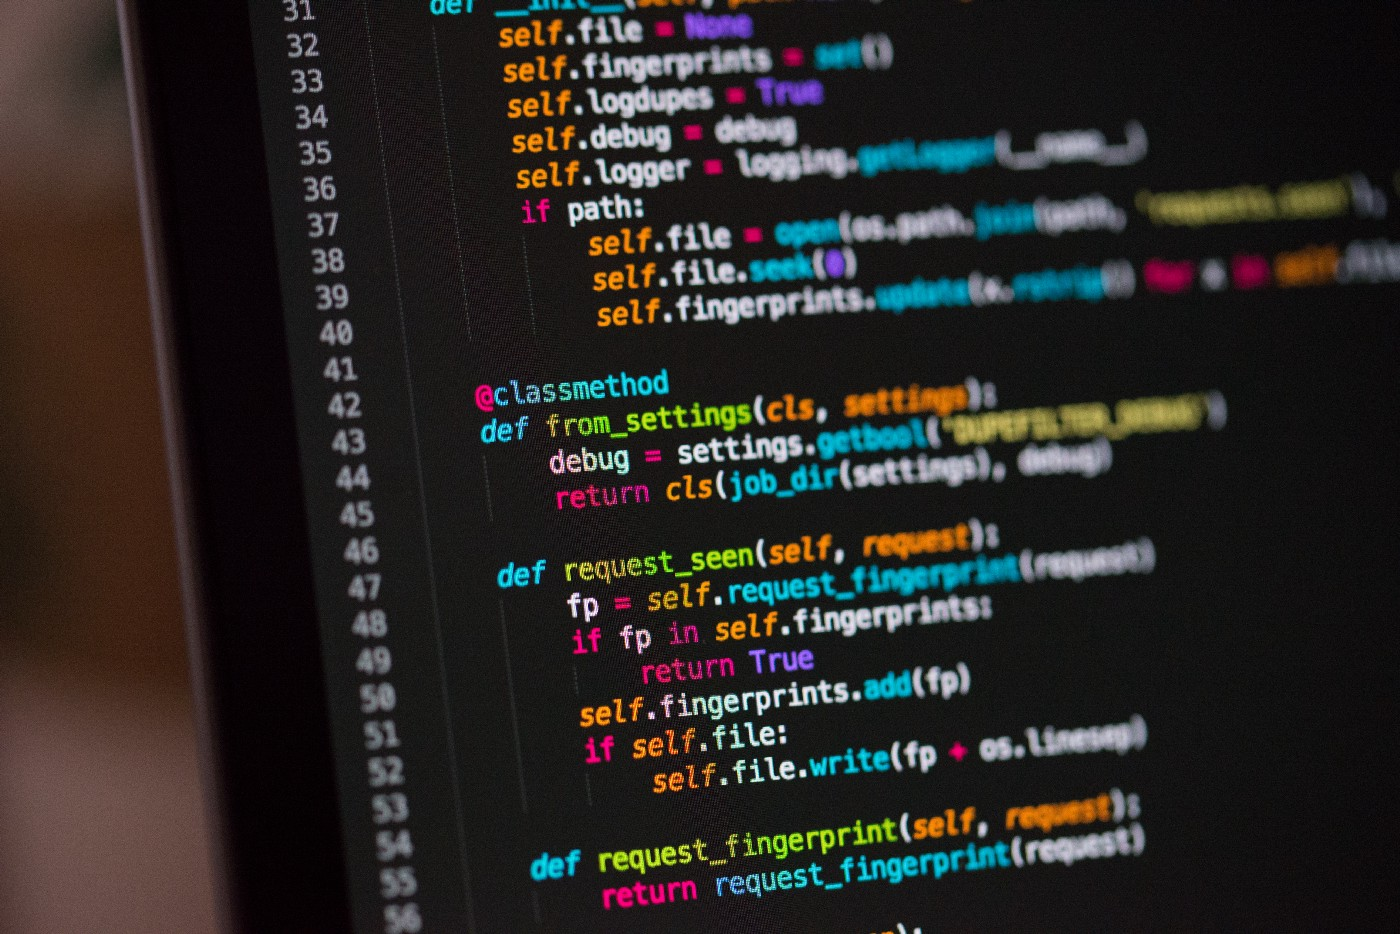

Let's now code a method **play()**, which runs the game once:
* Our method should generate a **sequence of states**, which ends either in state BED or in state WET.
* To do so, our method  get a **policy** (i.e., the agent's strategy).
* Our policy is **stochastic**: In each state, it will pick actions with certain probabilities. We model it as a dictionary with states as keys. For each state s, policy[s] is a list of action-probability pairs, e.g. [(left,0.25), (right,0.5), (stay,0.25)].

In the next cell, ...
1. implement play()
2. define a dummy policy which just runs to the target and back, regardless of the weather.
3. play the game and observe the resulting sequence.

In [ ]:
import random
import numpy as np
from scipy.stats import multinomial

def choose_transition(s,a,env):
    ''' when picking action a in state s, compute a random follow-up
        state s' according to the environment's transition model. ''' 
    next_states = list(env.transitions()[s][a].items()) # (state,prob) pairs
    probs = [prob for a,prob in next_states]
    selected = int(np.where(multinomial.rvs(1, p=probs))[0])
    return next_states[selected][0]
    
def choose_action(policy, s):
    ''' when in a state s, choose the next action a according to 
        the policy.'''
    probs = [prob for a,prob in policy[s]]
    selected = int(np.where(multinomial.rvs(1, p=probs))[0])
    return policy[s][selected][0]
    
def play(env, policy, start=None):
    ''' Given an environment and a policy, run the agent.
        Return the resulting state sequence as a list of states/tuples. '''
    s = start if start else env.start()
    seq = [s]
    while not env.is_final(s):
        a = choose_action(policy,s)      
        s = choose_transition(s,a,env)
        seq.append(s)
    return seq

        
def dummy_policy():
    always_right = [(-1,0),(1,1),(0,0)]
    always_left = [(-1,1),(1,0),(0,0)]
    def _dummy_action(s):
        return always_left if s[-1] else always_right
    return { s:_dummy_action(s) for s in env.states() }

# visualizing episodes
policy = dummy_policy()

for i in range(1):
    seq = play(env,policy)
    print(seq)


## 5. Visualizing the Game
I have prepared another visualizer object, which gives us an animation of a play...
In the cell below, you can generate state sequences with play() and then visualize them. The blue timeline on the left illustrates the recent rain chance.

In [ ]:
#########################################################################
############           NO NEED TO TOUCH THIS      #######################
#########################################################################

import plotly
import matplotlib.image as image
import numpy as np
import plotly.graph_objects as go
import time


class RunVisualizer:
    
    def __init__(self, env, sleep=0.5):
        self.sleep = sleep
        self.env = env
        self.T = env.T
        self.fig = go.FigureWidget()
        self.fig.update_yaxes(range=[0, 1])
        self.fig.update_xaxes(range=[-1.5, self.T+1-0.5])
        # add background image
        self.fig.add_layout_image(
            dict(
                source='https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2022-Lab/main/lab_6/background.jpg',
                xref="x",
                yref="y",
                x=-0.5,
                y=1,
                sizex=self.T+1,
                sizey=1,
                sizing="stretch",
                opacity=1,
                layer="below")
        )
        # add scatter plot
        self.fig.add_trace(
            go.Scatter(x=[-1, -0.5, 0], y=[0.5, 0.2, 0.8]))
        # load image of jogger to display
        img_right = image.imread('https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2022-Lab/main/lab_6/jogger_small.png')
        img_right[:,:,:3] *= 255                 # range [0,1]->[0,255]
        img_right[:,:,:] = img_right[::-1,:,:]   # flip vertically
        img_left = img_right[:,::-1,:]           # a second image of the jogger running left.
        self.img_right = img_right
        self.img_left = img_left
        # add jogger image to plot
        self.fig.add_trace(go.Image(z=img_right, colormodel='rgba', x0=3, y0=.1, dx=0.0061, dy=0.0061))
        # display(self.fig)
        
        # show figure
        self.fig.show()
        
    def next_state(self, i, seq):
        state = seq[i]
        pos,rain_chance,reached_target = state
        # set barplot
        y = np.array([s[1] for j,s in enumerate(seq) if j<=i])
        if state == self.env.WET:
            y[-1] = 100.
        elif state == self.env.BED:
            y[-1] = y[-2]
        y = (y/100.)[-5:]
        y = np.clip(y, 0.03, 0.97)
        #y = [v/100. for v in [s[1] for s in seq][:-5]]
        self.fig.data[0]['y'] = y
        self.fig.data[0]['x'] = np.arange(-1.5,-1.5+0.2*len(y),0.2)
        # set position
        if state == self.env.BED:
            pos = 0
        elif state == self.env.WET:
            pos = -100
        self.fig.data[1]['x0'] = pos-0.3
        # set jogger image (left/right)
        self.fig.data[1]['z'] = self.img_left if reached_target else self.img_right
        time.sleep(self.sleep)
        
        # clear display output and show figure
        display.clear_output(wait=True)
        self.fig.show()


In [ ]:
def plot(seq,env,vis):
    for i,s in enumerate(seq):
        vis.next_state(i, seq)

env = JoggingEnvironment(T=5)
vis = RunVisualizer(env=env, sleep=0.25)
policy = dummy_policy()

for i in range(10):
    seq = play(env,policy)
    plot(seq, env, vis)
    time.sleep(1)

## 6. Training with Dynamic Programming
Let us now implement the training of a better agent, using the dynamic programming approach from lecture:
* The agent starts with a totally random policy (i.e., an $\epsilon$-greedy policy with $\epsilon$=1).
* We alternative between (a) updating the states' value functions (**policy evaluation**), and (b) updating the policy by lowering $\epsilon$ (**policy improvement**).

There is already a bit of code which defines the epsilon-greedy policy and chooses the best action from it. Let's implement the training loop...

In [ ]:
NITERS_DYNAMIC = 50
NITERS_MONTE_CARLO = 5
NITERS_POLICY_ITERATION = 40

############### HELP METHODS ##########################
        
        
def best_action(s, values, transitions):
    '''given a state and the value function, compute the best action
       according to the Bellman Equation.'''
    q = {}
    for a in transitions[s]:
        q[a] = sum([Pnews*values[news] for news,Pnews in transitions[s][a].items()])
        #if s==(1,0,1):
        #    print('???', a)
        #    for news,Pnews in transitions[s][a].items():
        #        print(' -> news =', news, 'P =', Pnews, 'V =', values[news])
    besta,bestq = sorted(q.items(), key=lambda x:x[-1], reverse=True)[0]
    return besta

def eps_greedy_policy(v, eps, env):
    '''given a value function, compute the epsilon-greedy policy.
       policy[s] is a list of (a,P) pairs where a is an action and
       P is its probability of picking the action according to the policy.'''
    policy = {}
    best_actions = {}
    for s in env.states():
        if not env.transitions()[s]:
            continue
        valid_actions = [a for a in env.actions() if a in env.transitions()[s]]
        P = 1./len(valid_actions)
        if eps==1:
            policy[s] = [(a,P) for a in valid_actions]
        else:
            abest = best_action(s,v,env.transitions())
            policy[s] = [(a,eps*P + (1-eps)*(a==abest)) for a in valid_actions]
            best_actions[s] = abest
            #if s==(1,0,1):
            #    print('valid_actions', valid_actions)
            #    print('best action', abest)
    return policy, best_actions



############### ACTUAL TRAINING LOOP ##########################

def evaluate_policy_dynamic_programming(env, policy, gamma):

    states = env.states()
    transitions = env.transitions()
    
    # initialize value function
    v = {s:0. for s in states}
    
    # training iterations
    for i in range(NITERS_DYNAMIC):

        newv = {}
    
        for s in states:
            r = env.reward(s)
            v_ = 0.
            if transitions[s]: # -> s is not terminal
                for (a,Pa) in policy[s]:
                    v_ += Pa * ( sum([Pnews*v[news]
                                      for news,Pnews
                                      in transitions[s][a].items()]) )
                #if s == (1,0,1):
                #    print(i, '> Evaluating', s)
                #    for (a,Pa) in policy[s]:
                #        print('action', a)
                #        for news,Pnews in transitions[s][a].items():
                #            print(news, '(', Pnews, ') : ', v[news])
                #    print('> RESULT =', v_, r + gamma*v_)
                
            newv[s] = r + gamma * v_
    
        v = newv
    
    return v


def evaluate_policy_monte_carlo(env, policy, gamma, v, beta):
    '''this updates v using monte carlo sampling.'''
    states = env.states()

    for i in range(NITERS_MONTE_CARLO):
        
        for start in states:
            
            episode = play(env, policy, start=start)
            
            v_est = 0.
            for s in episode[::-1]:
                v_est = env.reward(s) + gamma * v_est
                v[s] = v[s] + beta * (v_est-v[s])
                
    return v



def train(env, iterations, eps_factor, use_monte_carlo=False, eps0=1., gamma=0.5, visualizer=None, beta=0.02):
    
    v = {s:0. for s in env.states()}
    eps = eps0
    eps_policy,_ = eps_greedy_policy(v, eps, env)

    for i in range(iterations):

        # policy evaluation
        if use_monte_carlo:
            v = evaluate_policy_monte_carlo(env, eps_policy, gamma, v, beta)
        else:
            v = evaluate_policy_dynamic_programming(env, eps_policy, gamma)
        
        # policy optimization
        eps_policy, best_actions = eps_greedy_policy(v, eps, env)
        #print(eps_policy)
        result_policy = eps_greedy_policy(v, eps=0., env=env)

        if visualizer and i<10 or i % 10 == 0:
            visualizer.update_title('Iteration %d (eps=%.2f)' %(i,eps))
            visualizer.update_node_values(v, best_actions)
            time.sleep(0.5)
        
        if i==0 or i==99:
            pass
            #print(i)
            #print_policy(policy)

        eps *= eps_factor
    
    return result_policy, v

vis = StateSpaceVisualizer(env)

policy = train(env, iterations=300, use_monte_carlo=True, eps_factor=0.99, eps0=1.0, gamma=0.99, visualizer=vis)
